## Реализовать и обучить (с нуля) СНС для задачи классификации изображений на датасете CIFAR-10

Библиотеки: [Python, Tensorflow]

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os


Using TensorFlow backend.


## Загрузка и подготовка датасета CIFAR10

In [3]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()



In [4]:
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [5]:
np.unique(train_y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [6]:
some_samples = test_y[:16, ...]
print(*some_samples)

[3] [8] [8] [0] [6] [6] [1] [6] [3] [1] [0] [9] [5] [7] [9] [8]


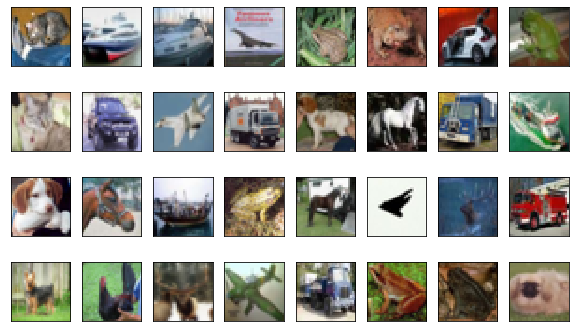

In [7]:
some_samples = test_x[:32, ...]

fig = plt.figure(figsize=(10, 6))
for j in range(some_samples.shape[0]):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j])
    plt.xticks([]), plt.yticks([])
plt.show()

In [8]:
train_x = train_x.reshape(-1, 32, 32, 3).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 32, 32, 3).astype(np.float32) / 255.

# np(train_x, axis=3) = np.mean(train_x, axis=3)
# test_x  = np.mean(test_x, axis=3)

train_y = train_y.astype(np.int32)
test_y = test_y.astype(np.int32)

print(train_x.shape, train_x.dtype)
print(test_x.shape, test_x.dtype)
print(train_y.shape, train_y.dtype)
print(test_y.shape, test_y.dtype)



(50000, 32, 32, 3) float32
(10000, 32, 32, 3) float32
(50000, 1) int32
(10000, 1) int32


In [9]:
train_y = train_y.flatten()
test_y = test_y.flatten()

## Создание пайплайна данных

In [14]:
NUM_EPOCHS = 4
BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)


In [13]:
train_ds

<BatchDataset shapes: ((None, 32, 32, 3), (None,)), types: (tf.float32, tf.int32)>

## Создание модели CNN

In [10]:
class Model(tf.keras.Model):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same')
        self.conv2 = tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same')
        self.conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')  
        self.avg_pool = tf.keras.layers.AveragePooling2D((2, 2), (2, 2))
        self.max_pool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2))
        self.fc1 = tf.keras.layers.Dense(64, activation='relu')
        self.fc2 = tf.keras.layers.Dense(10, activation='softmax')
        self.max_pool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same')
        self.flatten = tf.keras.layers.Flatten()
        self.dropout =  tf.keras.layers.Dropout(0.3)
        
    def call(self, inp):

        out = self.conv1(inp)
        out = self.avg_pool(out)
        out = self.dropout(out)

        out = self.conv2(out)
        out = self.max_pool(out)
        out = self.dropout(out)
        out = self.conv3(out)
        out = self.max_pool(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out
    
model = Model()

In [11]:
def loss(logits, labels):
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
      logits=logits, labels=labels))


def accuracy(logits, labels):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), dtype=tf.float32))

In [15]:
LEARNING_RATE = 0.001

# optimizer = tf.keras.optimizers.SGD(LEARNING_RATE)
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

# writer = tf.summary.create_file_writer('logs/sgd')
writer = tf.summary.create_file_writer('logs/adam')

## Цикл обучения модели

In [16]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        logits = model(images)
#         print(logits.shape)
        loss_value = loss(logits, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    # Calc and display loss/accuracy
    if iteration % 200 == 0:
        test_logits = model(test_x[:256, ...])
        accuracy_value = accuracy(test_logits, test_y[:256, ...])
        
        print("[%4d] Accuracy: %5.2f %%" % (
            iteration, accuracy_value.numpy()*100))
        
        with writer.as_default():
            tf.summary.scalar('accuracy', accuracy_value, iteration)
            tf.summary.scalar('loss', loss_value, iteration)

[   0] Accuracy:  9.38 %
[ 200] Accuracy: 28.12 %
[ 400] Accuracy: 31.64 %
[ 600] Accuracy: 35.16 %
[ 800] Accuracy: 37.89 %
[1000] Accuracy: 30.08 %
[1200] Accuracy: 38.67 %
[1400] Accuracy: 41.80 %
[1600] Accuracy: 42.97 %
[1800] Accuracy: 43.36 %
[2000] Accuracy: 42.58 %
[2200] Accuracy: 45.70 %
[2400] Accuracy: 48.83 %
[2600] Accuracy: 46.48 %
[2800] Accuracy: 40.62 %
[3000] Accuracy: 47.66 %
[3200] Accuracy: 50.39 %
[3400] Accuracy: 50.39 %
[3600] Accuracy: 51.95 %
[3800] Accuracy: 50.39 %
[4000] Accuracy: 51.17 %
[4200] Accuracy: 50.39 %
[4400] Accuracy: 52.34 %
[4600] Accuracy: 53.12 %
[4800] Accuracy: 55.86 %
[5000] Accuracy: 53.52 %
[5200] Accuracy: 52.34 %
[5400] Accuracy: 49.61 %
[5600] Accuracy: 53.12 %
[5800] Accuracy: 53.52 %
[6000] Accuracy: 56.25 %
[6200] Accuracy: 53.52 %
Wall time: 26min 39s


Оценка качества модели

In [17]:
%%time

test_logits = model(test_x)
accuracy_value = accuracy(test_logits, test_y).numpy()
print("Final Accuracy: %5.2f %%" % (accuracy_value * 100))



Final Accuracy: 54.25 %
Wall time: 2min 28s


## Функция для инференса и отображения результата предсказания

In [18]:
def test_item(sample):
    
    logits = model(sample[None, ...])[0]
    prediction = tf.nn.softmax(logits)
    ans = np.argmax(prediction)
    
    fig = plt.figure(figsize=(12,4))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(sample[:,:,0], cmap='gray')
    plt.xticks([]), plt.yticks([])

    ax = fig.add_subplot(1, 2, 2)
    bar_list = ax.bar(np.arange(10), prediction, align='center')
    bar_list[ans].set_color('g')
    ax.set_xticks(np.arange(10))
    ax.set_xlim([-1, 10])
    ax.grid(True)

    plt.show()
    
    print('Predicted: {}'.format(ans))

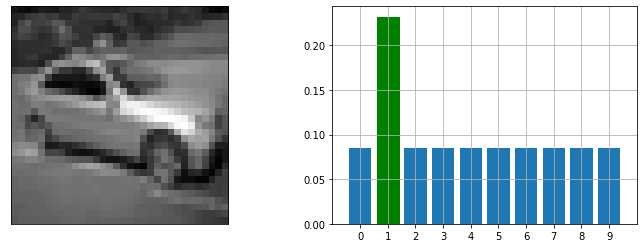

Predicted: 1
True Answer: 1


In [19]:
import random
idx = random.randint(0, test_x.shape[0])
sample = test_x[idx, ...]
test_item(sample)

print('True Answer: {}'.format(test_y[idx]))